![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 11 - Non-linear Least Squares</center>
### <center> Levenberg–Marquardt </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/11_NonLinearLeastSquares/MainLevenbergMarquardt.ipynb)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

### The model $f$:
$$f\left(x\right)=Ae^{-\gamma x}\sin\left(\omega x+\phi\right)$$
with unknown parameters: $A,\gamma,\omega,\phi$


### Using SymPy to compute the function value and all other derivatives:

In [2]:
import sympy

#-- Just a nice printing:
def Show(lhs, rhs):
    return sympy.Eq(sympy.Dummy(lhs), rhs, evaluate=False)
    
x = sympy.Symbol('x',     real=True)
A = sympy.Symbol('A',     real=True)
γ = sympy.Symbol('gamma', real=True)
ω = sympy.Symbol('omega', real=True)
ϕ = sympy.Symbol('phi',   real=True)

f = A * sympy.exp(-γ*x) * sympy.sin(ω*x + ϕ)
Show('f(x)', f)

Eq(_f(x), A*exp(-gamma*x)*sin(omega*x + phi))

### Compute the (symbolic) gradient of  $f$:

In [3]:
from sympy.tensor.array import derive_by_array

#-- Gradient:
def D(f, lW):
    return sympy.Matrix(derive_by_array(f, lW))

#-- Hessian:
def DD(f, lW):
    return sympy.Matrix(derive_by_array(derive_by_array(f, lW), lW))

#-- Compute gradient w.r.t these:
lW = [A, γ, ω, ϕ]

Show('∇_{w}f', D(f, lW))

Eq(_∇_{w}f, Matrix([
[     exp(-gamma*x)*sin(omega*x + phi)],
[-A*x*exp(-gamma*x)*sin(omega*x + phi)],
[ A*x*exp(-gamma*x)*cos(omega*x + phi)],
[   A*exp(-gamma*x)*cos(omega*x + phi)]]))

### Compute the (symbolic) Hessian of $f$:

In [4]:
Show('∇_{w}^2f', DD(f, lW))

Eq(_∇_{w}^2f, Matrix([
[                                  0,      -x*exp(-gamma*x)*sin(omega*x + phi),       x*exp(-gamma*x)*cos(omega*x + phi),      exp(-gamma*x)*cos(omega*x + phi)],
[-x*exp(-gamma*x)*sin(omega*x + phi),  A*x**2*exp(-gamma*x)*sin(omega*x + phi), -A*x**2*exp(-gamma*x)*cos(omega*x + phi), -A*x*exp(-gamma*x)*cos(omega*x + phi)],
[ x*exp(-gamma*x)*cos(omega*x + phi), -A*x**2*exp(-gamma*x)*cos(omega*x + phi), -A*x**2*exp(-gamma*x)*sin(omega*x + phi), -A*x*exp(-gamma*x)*sin(omega*x + phi)],
[   exp(-gamma*x)*cos(omega*x + phi),    -A*x*exp(-gamma*x)*cos(omega*x + phi),    -A*x*exp(-gamma*x)*sin(omega*x + phi),   -A*exp(-gamma*x)*sin(omega*x + phi)]]))

### Symbolic expressions to functions:

In [5]:
from sympy.utilities.lambdify import lambdify

Lambdaf   = lambdify([x, *lW], f        ) #-- function value
LambdaDf  = lambdify([x, *lW], D(f, lW) ) #-- gradient
LambdaDDf = lambdify([x, *lW], DD(f, lW)) #-- Hessian

def f(x, vW):
    return Lambdaf(x, *vW)

def Df(x, vW):
    return LambdaDf(x, *vW)
    
def DDf(x, vW):
    return LambdaDDf(x, *vW)

### Generate some data:
$$y_{i}=f\left(x_{i},\boldsymbol{w}\right)+\epsilon_{i}$$

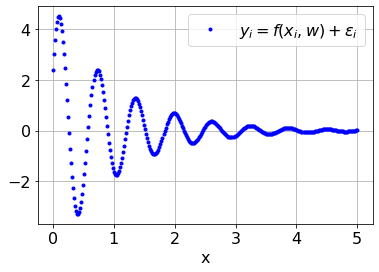

In [6]:
N  = 301
vX = np.linspace(0, 5, N)
vW = [5, 1, 10, .5] #-- [A, γ, ω, ϕ]
vY = f(vX, vW) + 1 * np.random.randn(N) / 10000
    
plt.plot(vX, vY, '.b', lw=2, label='$y_i = f(x_i, w) + \epsilon_i$')
plt.grid()
plt.xlabel('x')
plt.legend()
plt.show()

### Residuals and Jacobian:
$$\boldsymbol{r}\left(\boldsymbol{w}\right)=\left[\begin{matrix}y_{1}\\
\vdots\\
y_{N}
\end{matrix}\right]-\left[\begin{matrix}f\left(x_{1},\boldsymbol{w}\right)\\
\vdots\\
f\left(x_{N},\boldsymbol{w}\right)
\end{matrix}\right]=\boldsymbol{y}-f\left(\boldsymbol{x},\boldsymbol{w}\right)$$

$$\boldsymbol{J}\left(\boldsymbol{w}\right)=\left[\begin{matrix}\text{---}\hspace{-0.2cm} & \nabla^{T}r_{1}\left(\boldsymbol{w}\right) & \hspace{-0.2cm}\text{---}\\
 & \vdots\\
\text{---}\hspace{-0.2cm} & \nabla^{T}r_{N}\left(\boldsymbol{w}\right) & \hspace{-0.2cm}\text{---}
\end{matrix}\right]=\left[\begin{matrix}\text{---}\hspace{-0.2cm} & -\nabla_{\boldsymbol{w}}^{T}f\left(x_{1},\boldsymbol{w}\right) & \hspace{-0.2cm}\text{---}\\
 & \vdots\\
\text{---}\hspace{-0.2cm} & -\nabla_{\boldsymbol{w}}^{T}f\left(x_{N},\boldsymbol{w}\right) & \hspace{-0.2cm}\text{---}
\end{matrix}\right]$$

In [7]:
def Residuals(vW):
    return vY - f(vX, vW)
    
def Jacobian(vW):
    return -Df(vX, vW).squeeze().T

### Objective:
$$L\left(\boldsymbol{w}\right)=\frac{1}{2N}\left\Vert \boldsymbol{r}\left(\boldsymbol{w}\right)\right\Vert _{2}^{2}$$
$$\nabla L\left(\boldsymbol{w}\right)=\frac{1}{N}\boldsymbol{J}^{T}\left(\boldsymbol{w}\right)\boldsymbol{r}\left(\boldsymbol{w}\right)$$
$$\nabla^{2}L\left(\boldsymbol{w}\right)=\frac{1}{N}\sum_{i=1}^{N}\nabla^{2}r_{i}\left(\boldsymbol{w}\right)\cdot r_{i}\left(\boldsymbol{w}\right)+\boldsymbol{J}\left(\boldsymbol{w}\right)\boldsymbol{J}^{T}\left(\boldsymbol{w}\right)$$

In [8]:
def L(vW):
    return 1/(2) * np.linalg.norm(Residuals(vW))**2

def DL(vW):
    vR = Residuals(vW)
    mJ = Jacobian(vW) 
    
    return mJ.T @ vR

def DDL(vW):
    vR = Residuals(vW)
    mJ = Jacobian(vW) 
    mH = mJ.T @ mJ
    
    for ii in range(N):
        mH += -DDf(vX[ii], vW) * vR[ii]
    
    return mH

### Vanilla gradient descent:
$$\boldsymbol{w}^{\left(t\right)}=\boldsymbol{w}^{\left(t-1\right)}-\mu\nabla L\left(\boldsymbol{w}\right)$$

In [9]:
import time

def GradientDescent(f, Df, vX0, µ, K):
    vF    = np.full(K, np.nan)
    vTime = np.full(K, np.nan)

    vX       = vX0.copy()
    vF[0]    = f(vX)
    vTime[0] = time.time()
    for ii in range(1, K):
        vX -= µ * Df(vX)

        vTime[ii] = time.time()
        vF[ii]    = f(vX)

    vTime -= vTime[0]
    return vF, vTime

### Gradient descent with line search:
$$\boldsymbol{w}^{\left(t\right)}=\boldsymbol{w}^{\left(t-1\right)}-\alpha^{\left(t\right)}\nabla L\left(\boldsymbol{w}\right)$$

In [10]:
def GradientDescentWithLineSearch(f, Df, vX0, α0, c, K):
    vF    = np.full(K, np.nan)
    vTime = np.full(K, np.nan)

    vX       = vX0.copy()
    vF[0]    = f(vX)
    vTime[0] = time.time()
    for ii in range(1, K):
        vG   = Df(vX)            #-- gradient
        vH   = -vG               #-- descent direction
        m    = np.inner(vG, vH)  #-- slope
        f0   = vF[ii-1]

        #-- Line search:
        α    = α0
        fα   = f(vX + α * vH)
        while fα > f0 + c * α * m:
            α  *= .5
            fα  = f(vX + α * vH)

        α0        = 4 * α
        vX       += α * vH
        vTime[ii] = time.time()
        vF[ii]    = fα

    vTime -= vTime[0]
    return vF, vTime

### Newton's Method (using SciPy implementation):
$$\boldsymbol{h}^{\left(t\right)}=-\left(\nabla^{2}L\right)^{-1}\nabla L=-\boldsymbol{H}^{-1}\boldsymbol{g}$$
$$\boldsymbol{w}^{\left(t\right)}=\boldsymbol{w}^{\left(t-1\right)}+\alpha^{\left(t\right)}\boldsymbol{h}^{\left(t\right)}$$
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [11]:
from scipy.optimize import minimize

def NewtonsMethod(f, Df, DDf, vX0, K):
    
    lF    = []
    lTime = []

    lF.append(f(vX0))
    lTime.append(time.time())
    
    def Callback(vX):
        lF.append(f(vX))
        lTime.append(time.time())
    
    oRes = minimize(f, vX0, jac=Df, hess=DDf, method='Newton-CG', options={'maxiter':K}, callback=Callback)
#     print(oRes)
    
    vF    = np.array(lF)
    vTime = np.array(lTime)

    vTime -= vTime[0]
    return vF, vTime

### Gauss-Newton:
$$\boldsymbol{h}^{\left(t\right)}=-\boldsymbol{J}^{\dagger}\boldsymbol{r}=\left(\boldsymbol{J}^{T}\boldsymbol{J}\right)^{-1}\boldsymbol{J}^{T}\boldsymbol{r}=\tilde{\boldsymbol{H}}^{-1}\boldsymbol{g}$$
$$\boldsymbol{w}^{\left(t\right)}=\boldsymbol{w}^{\left(t-1\right)}+\alpha^{\left(t\right)}\boldsymbol{h}^{\left(t\right)}$$

In [12]:
def GaussNewton(L, Residuals, Jacobian, vW0, α0, c, K):
    vL    = np.full(K, np.nan)
    vTime = np.full(K, np.nan)

    vW       = vW0.copy()
    vL[0]    = L(vW)
    vTime[0] = time.time()
    for ii in range(1, K):
        vR   = Residuals(vW)               #-- Residuals
        mJ   = Jacobian(vW)                #-- Jacobian
        vH   = np.linalg.lstsq(-mJ, vR)[0] #-- descent direction
        
        vG   = mJ.T @ vR / N               #-- gradient ∇L = J^T * r / N
        m    = np.inner(vG, vH)            #-- slope
        L0   = vL[ii-1]

        #-- Line search:
        α    = α0
        Lα   = L(vW + α * vH)
        while (Lα > L0 + c * α * m) and (α > 1e-10):
            α  *= .5
            Lα  = L(vW + α * vH)

        α0        = 4 * α
        vW       += α * vH
        vTime[ii] = time.time()
        vL[ii]    = Lα

    vTime -= vTime[0]
    return vL, vTime

### Levenberg-Marquardt:
$$\boldsymbol{h}^{\left(t\right)}=-\left(\boldsymbol{J}^{T}\boldsymbol{J}+\mu^{\left(t\right)}\boldsymbol{I}\right)^{-1}\boldsymbol{J}^{T}\boldsymbol{r}$$
$$\boldsymbol{w}^{\left(t\right)}=\boldsymbol{w}^{\left(t-1\right)}+\boldsymbol{h}^{\left(t\right)}$$

In [13]:
from numpy.linalg import norm

def LevenbergMarquardt(L, Residuals, Jacobian, vW0, K):
    vL    = np.full(K, np.nan)
    vTime = np.full(K, np.nan)

    ε1       = 1e-20
    ε2       = 1e-20
    factor   = 2
    mI       = np.eye(len(vW0))
    
    vW       = vW0.copy()
    vL[0]    = L(vW)
    vTime[0] = time.time()
    
    vR = Residuals(vW)
    mJ = Jacobian(vW)
    mH = mJ.T @ mJ
    vG = mJ.T @ vR
    
    #-- Gradient stopping criterion:
    if norm(vG, ord=np.inf) < ε1:
        return vL, 0
    
    #-- Damping factor:
    µ = np.max(mH)
    
    for ii in range(1, K):
        #-- Descent direction:
        vH   = np.linalg.lstsq(mH + µ * mI, -vG)[0]
        
        #-- Step stopping criterion:
        if norm(vH) < ε2 * norm(vW + ε2):
            break
        
        L0    = L(vW)
        vWnew = vW + vH
        ρ     = N * (L0 - L(vWnew)) / (1/2 * np.inner(vH, µ*vH - vG))
        
        #-- Accept step?
        if  ρ > 0: 
            vW = vWnew
            vR = Residuals(vW)
            mJ = Jacobian(vW)
            mH = mJ.T @ mJ
            vG = mJ.T @ vR
            
            #-- Gradient stopping criterion:
            if norm(vG, ord=np.inf) < ε1:
                break
                
            #-- Update µ:
            µ      *= np.max([1/3, 1 - (2*ρ - 1)**3])
            factor  = 2
        else:
            µ      *= factor
            factor *= 2

        vTime[ii] = time.time()
        vL[ii]    = L0

    vTime -= vTime[0]
    return vL, vTime

In [14]:
#-- These are the correct parameters:
vW #-- [A, γ, ω, ϕ]

[5, 1, 10, 0.5]

### Plot the initial guess:

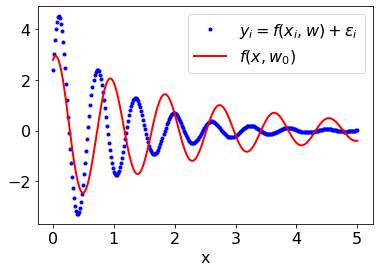

In [15]:
# vW0 = 5 * np.random.rand(4)
vW0 = np.array([3, 0.4, 7, 1.2])
# vW0 = np.array([5, 1, 8, .6])

xx =np.linspace(0, 5, 1001)
plt.plot(vX, vY,         '.b', lw=2, label='$y_i=f(x_i, w) + \epsilon_i$')
plt.plot(xx, f(xx, vW0), 'r',  lw=2, label='$f(x, w_0)$')
plt.xlabel('x')
plt.legend()
plt.show()

### Run algorithms:

In [16]:
#-- GD:
µ                     = .8 #-- step size:
K                     = 250 #-- number of iterations:
vObjectiveGD, vTimeGD = GradientDescent(L, DL, vW0, µ, K)

#-- GD with LS:
α0                    = 1
c                     = 0.5
K                     = 125
vObjectiveLS, vTimeLS = GradientDescentWithLineSearch(L, DL, vW0, α0, c, K)

#-- Newtho's method:
K                     = 200
vObjectiveNM, vTimeNM = NewtonsMethod(L, DL, DDL, vW0, K)

#-- Gauss-Newtho:
α0                    = 1
c                     = 0.5
K                     = 100
vObjectiveGN, vTimeGN = GaussNewton(L, Residuals, Jacobian, vW0, α0, c, K)

#--Levenberg-Marquardt:
τ                     = 0.01
K                     = 100
vObjectiveLM, vTimeLM = LevenbergMarquardt(L, Residuals, Jacobian, vW0, K)

<ipython-input-12-a89015956d5a>:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  vH   = np.linalg.lstsq(-mJ, vR)[0] #-- descent direction
<ipython-input-13-4495dff8dc6d>:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  vH   = np.linalg.lstsq(mH + µ * mI, -vG)[0]


### Plot:

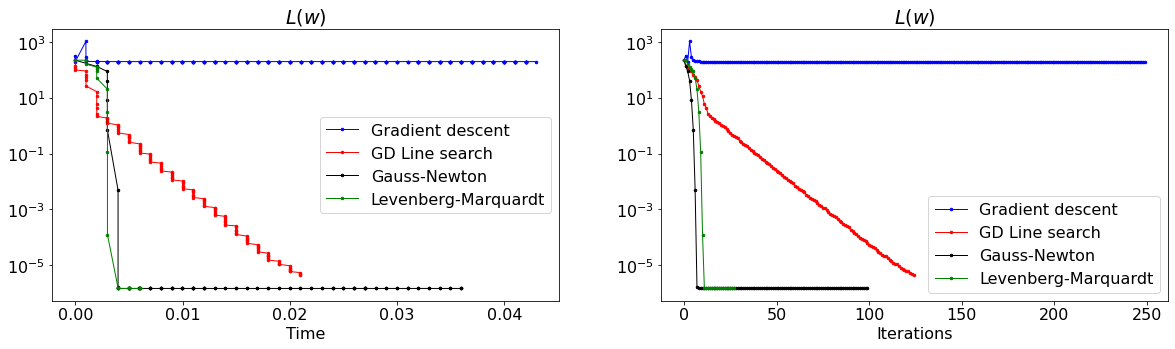

In [17]:
_, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].plot(vTimeGD, vObjectiveGD, c='b', lw=1, marker='.', ms=5, label='Gradient descent')
axes[0].plot(vTimeLS, vObjectiveLS, c='r', lw=1, marker='.', ms=5, label='GD Line search')
# axes[0].plot(vTimeNM, vObjectiveNM, c='m', lw=1, marker='.', ms=5, label="Newton's Method")
axes[0].plot(vTimeGN, vObjectiveGN, c='k', lw=1, marker='.', ms=5, label='Gauss-Newton')
axes[0].plot(vTimeLM, vObjectiveLM, c='g', lw=1, marker='.', ms=5, label='Levenberg-Marquardt')
axes[0].set_title('$L(w)$')
axes[0].set_xlabel('Time')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot(vObjectiveGD, c='b', lw=1, marker='.', ms=5, label='Gradient descent')
axes[1].plot(vObjectiveLS, c='r', lw=1, marker='.', ms=5, label='GD Line search')
# axes[1].plot(vObjectiveNM, c='m', lw=1, marker='.', ms=5, label="Newton's Method")
axes[1].plot(vObjectiveGN, c='k', lw=1, marker='.', ms=5, label="Gauss-Newton")
axes[1].plot(vObjectiveLM, c='g', lw=1, marker='.', ms=5, label='Levenberg-Marquardt')
axes[1].set_title('$L(w)$')
axes[1].set_xlabel('Iterations')
axes[1].set_yscale('log')
axes[1].legend()
plt.show()

### Let's try a different starting point:

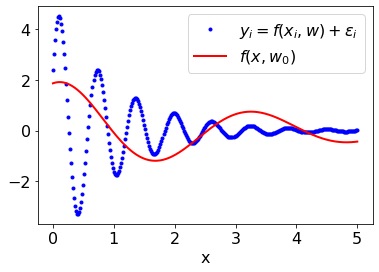

In [18]:
vW0 = np.array([2, 0.3, 2, 1.2])

xx =np.linspace(0, 5, 1001)
plt.plot(vX, vY,         '.b', lw=2, label='$y_i=f(x_i, w) + \epsilon_i$')
plt.plot(xx, f(xx, vW0), 'r',  lw=2, label='$f(x, w_0)$')
plt.xlabel('x')
plt.legend()
plt.show()

### Run algorithms:

In [19]:
#-- GD:
µ                     = .8 #-- step size:
K                     = 250 #-- number of iterations:
vObjectiveGD, vTimeGD = GradientDescent(L, DL, vW0, µ, K)

#-- GD with LS:
α0                    = 1
c                     = 0.5
K                     = 125
vObjectiveLS, vTimeLS = GradientDescentWithLineSearch(L, DL, vW0, α0, c, K)

#-- Newtho's method:
K                     = 200
vObjectiveNM, vTimeNM = NewtonsMethod(L, DL, DDL, vW0, K)

#-- Gauss-Newtho:
α0                    = 1
c                     = 0.5
K                     = 100
vObjectiveGN, vTimeGN = GaussNewton(L, Residuals, Jacobian, vW0, α0, c, K)

#--Levenberg-Marquardt:
K                     = 100
vObjectiveLM, vTimeLM = LevenbergMarquardt(L, Residuals, Jacobian, vW0, K)

<ipython-input-12-a89015956d5a>:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  vH   = np.linalg.lstsq(-mJ, vR)[0] #-- descent direction
<ipython-input-13-4495dff8dc6d>:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  vH   = np.linalg.lstsq(mH + µ * mI, -vG)[0]


### Plot:

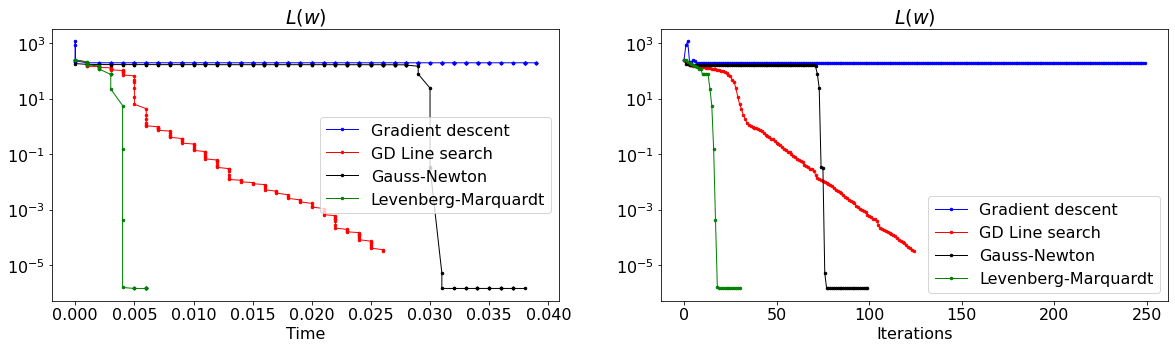

In [20]:
_, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].plot(vTimeGD, vObjectiveGD, c='b', lw=1, marker='.', ms=5, label='Gradient descent')
axes[0].plot(vTimeLS, vObjectiveLS, c='r', lw=1, marker='.', ms=5, label='GD Line search')
# axes[0].plot(vTimeNM, vObjectiveNM, c='m', lw=1, marker='.', ms=5, label="Newton's Method")
axes[0].plot(vTimeGN, vObjectiveGN, c='k', lw=1, marker='.', ms=5, label='Gauss-Newton')
axes[0].plot(vTimeLM, vObjectiveLM, c='g', lw=1, marker='.', ms=5, label='Levenberg-Marquardt')
axes[0].set_title('$L(w)$')
axes[0].set_xlabel('Time')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot(vObjectiveGD, c='b', lw=1, marker='.', ms=5, label='Gradient descent')
axes[1].plot(vObjectiveLS, c='r', lw=1, marker='.', ms=5, label='GD Line search')
# axes[1].plot(vObjectiveNM, c='m', lw=1, marker='.', ms=5, label="Newton's Method")
axes[1].plot(vObjectiveGN, c='k', lw=1, marker='.', ms=5, label="Gauss-Newton")
axes[1].plot(vObjectiveLM, c='g', lw=1, marker='.', ms=5, label='Levenberg-Marquardt')
axes[1].set_title('$L(w)$')
axes[1].set_xlabel('Iterations')
axes[1].set_yscale('log')
axes[1].legend()
plt.show()